# About 

    The objective of this challenge is to automate the process of estimating the soil parameters, specifically, potassium (K), phosphorus pentoxide (P2O5P_2O_5P2​O5​), magnesium (Mg) and pH, through extracting them from the airborne hyperspectral images captured over agricultural areas in Poland (the exact locations are not revealed). To make the solution applicable in real-life use cases, all the parameters should be estimated as precisely as possible.

    The dataset comprises 2886 patches in total (2 m GSD), of which 1732 patches for training and 1154 patches for testing. The patch size varies (depending on agricultural parcels) and is on average around 60x60 pixels. Each patch contains 150 contiguous hyperspectral bands (462-942 nm, with a spectral resolution of 3.2 nm), which reflects the spectral range of the hyperspectral imaging sensor deployed on-board Intuition-1.

    The participants are given a training set of 1732 training examples. The examples are hyperspectral image patches with the corresponding ground-truth information. Each masked patch corresponds to a field of interest, as presented in Fig. 1. Ground truth are the soil parameters obtained for the soil samples collected for each field of interest in the process of laboratory analysis, and is represented by a 4-value vector.



# References and Resources 

* Competition Page https://platform.ai4eo.eu/seeing-beyond-the-visible
* Starter code :  https://github.com/AI4EO/kp-labs-seeing-beyond-visible-challenge/blob/main/starter_pack.ipynb


# Dataset 
    
    The Dataset consists of Training and test dataset folders. The train folder has traiing image tiles, along with the concentration of elements (target), while the test folder has only the test images.
    
    The hyperspectral images consists of 150 bands (i.e 150 channels) ranging in wavelength from nm to nm . The task is to predict soil properties from these hyperspectral images.

# Imports 

In [1]:
import sys 
import os
import pandas as pd
import numpy as np
import glob
import gc


from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import multiprocessing as mp 

#plotting
import matplotlib.pyplot as plt 
import seaborn as sns
from termcolor import colored

import cv2
import tensorflow as tf 
import tensorflow.keras.backend as K




pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',50)



def  color_print(print_str,
                 print_color='green'):
    
    '''print in given  color (default green)'''
    print(colored(print_str,print_color))

In [2]:
class CFG:
    seed = 7
    img_size = (60,60)
    BATCH_SIZE = 32
    Autotune = tf.data.AUTOTUNE
    validation_size = 0.2
    
    classes = ['P','K','Mg','pH']
    class_dict= {0:'Phosphorous', 
                 1: 'Pottasium',
                 2: 'Magnesium',
                 3: 'PH'
                }

# Loading Dataset

**Helper Function**

In [3]:
def load_npz_file(filepath,
                  masked = True,
                  pad_mask = True):
    '''load in numpy zipped files. Use masked =True to mask masked values (pad with 0's)'''
    with np.load(filepath) as npz:
        arr = np.ma.MaskedArray(**npz)
        
        
    if masked == True:
        if pad_mask : # pad masked pixels with 0's to preserve shape 
            mask = arr.mask 
            return np.where(mask==True,0,arr.data)
        
        return arr

    return arr.data



In [4]:
train_folder = '../input/ai4eo-predict-soil-components-concentrations/RawData/train_data'


# hyperspectral image tiles 
train_tiles_folder = '../input/ai4eo-predict-soil-components-concentrations/RawData/train_data/train_data/' 

test_tiles_folder = '../input/ai4eo-predict-soil-components-concentrations/RawData/test_data'


In [5]:
train_gt = pd.read_csv(train_folder + '/train_gt.csv')
wavelength = pd.read_csv(train_folder + '/wavelengths.csv')

train_gt.head()

,sample_index,P,K,Mg,pH
0,0,45.1,188.0,179.0,7.2
1,1,44.8,205.0,188.0,7.0
2,2,44.4,207.0,145.0,6.8
3,3,46.5,204.0,143.0,6.8
4,4,52.0,212.0,167.0,6.7


In [6]:
#adding paths to train_gt csv 
train_gt['paths'] = train_tiles_folder + train_gt['sample_index'].astype(str) + '.npz'

#check if all the paths exists 

all([os.path.exists(path) for path in train_gt['paths']])

True

**Making a test csv**

In [7]:
test_csv = pd.DataFrame({'paths':glob.glob(test_tiles_folder+'/*.npz')})

test_csv['sample_index'] = test_csv['paths'].apply(lambda x:x.split('/')[-1].split('.')[0])
test_csv['sample_index'] = test_csv['sample_index'].astype(int)

test_csv.sort_values(by ='sample_index', inplace=True )
test_csv.reset_index(inplace=True,drop=True)
test_csv.head()

,paths,sample_index
0,../input/ai4eo-predict-soil-components-concent...,0
1,../input/ai4eo-predict-soil-components-concent...,1
2,../input/ai4eo-predict-soil-components-concent...,2
3,../input/ai4eo-predict-soil-components-concent...,3
4,../input/ai4eo-predict-soil-components-concent...,4


# Displaying some sample datapoints 

Shape of the selected sample image (150, 35, 38) (channels, height,width)


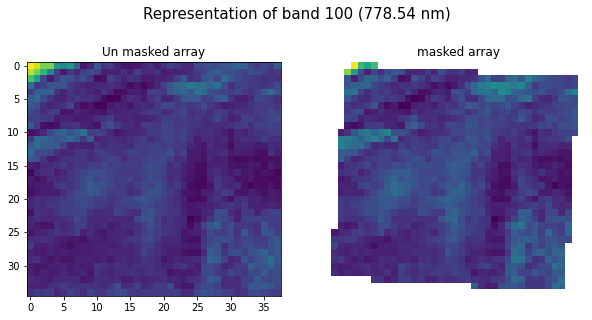

In [8]:
# display a single band 

#choose a sample 
rand_sample_path = train_gt.sample(n=1)['paths'].values[0]


with np.load(rand_sample_path) as f :
    arr = np.ma.MaskedArray(**f)


color_print(f'Shape of the selected sample image {arr.shape} (channels, height,width)')




fig, axs = plt.subplots(1, 2, figsize=(10, 5))
band_id = 100
wavelen = wavelength.loc[band_id-1]


axs[0].imshow(arr[band_id,:,:].data)
plt.axis('off')
axs[0].set_title('Un masked array')

axs[1].imshow(arr[band_id,:,:])
plt.axis('off')
axs[1].set_title('masked array')




plt.suptitle(f'Representation of band {int(wavelen["band_no"])} ({wavelen["wavelength"]} nm)', fontsize=15)
plt.show()

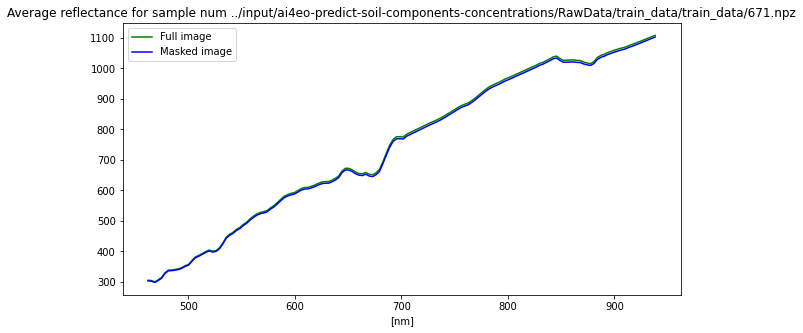

In [9]:
# displaying spectral curve 

fig,ax = plt.subplots(figsize=(10, 5))

masked_scene_mean_spectral_reflectance = [arr[i,:,:].mean() for i in range(arr.shape[0])]
full_scene_mean_spectral_reflectance = [arr[i,:,:].data.mean() for i in range(arr.shape[0])]

plt.plot(wavelength['wavelength'], full_scene_mean_spectral_reflectance, label='Full image',color='g')
plt.plot(wavelength['wavelength'], masked_scene_mean_spectral_reflectance, label='Masked image',color='b')

plt.xlabel('[nm]')
plt.legend()
plt.title(f'Average reflectance for sample num {rand_sample_path}')
plt.show()

Shape of the selected sample image (150, 90, 61) (channels, height,width)


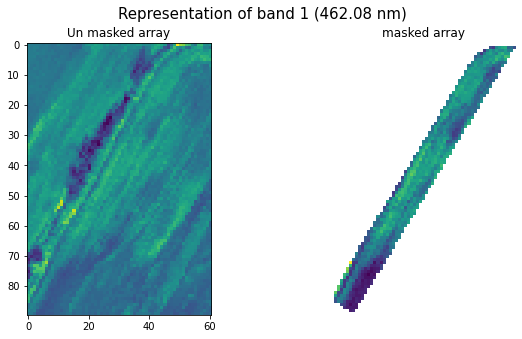

In [10]:
# display a single band 

#choose a sample 
rand_sample_path = train_gt.sample(n=1)['paths'].values[0]


with np.load(rand_sample_path) as f :
    arr = np.ma.MaskedArray(**f)

color_print(f'Shape of the selected sample image {arr.shape} (channels, height,width)')




fig, axs = plt.subplots(1, 2, figsize=(10, 5))
band_id = 1
wavelen = wavelength.loc[band_id-1]


axs[0].imshow(arr[band_id,:,:].data)
plt.axis('off')
axs[0].set_title('Un masked array')

axs[1].imshow(arr[band_id,:,:])
plt.axis('off')
axs[1].set_title('masked array')




plt.suptitle(f'Representation of band {int(wavelen["band_no"])} ({wavelen["wavelength"]} nm)', fontsize=15)
plt.show()

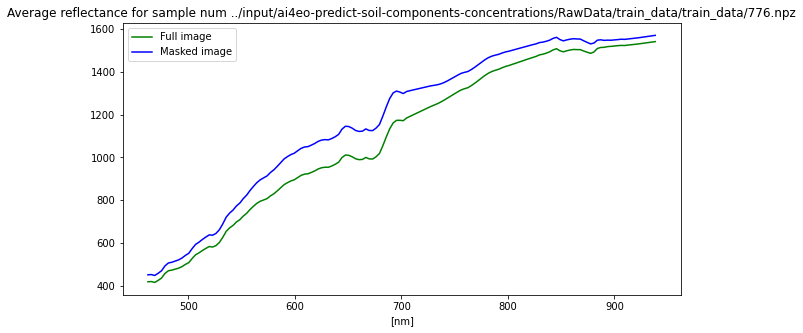

In [11]:
# displaying spectral curve 

fig,ax = plt.subplots(figsize=(10, 5))

masked_scene_mean_spectral_reflectance = [arr[i,:,:].mean() for i in range(arr.shape[0])]
full_scene_mean_spectral_reflectance = [arr[i,:,:].data.mean() for i in range(arr.shape[0])]

plt.plot(wavelength['wavelength'], full_scene_mean_spectral_reflectance, label='Full image',color='g')
plt.plot(wavelength['wavelength'], masked_scene_mean_spectral_reflectance, label='Masked image',color='b')

plt.xlabel('[nm]')
plt.legend()
plt.title(f'Average reflectance for sample num {rand_sample_path}')
plt.show()

Shape of the selected sample image (150, 89, 89) (channels, height,width)


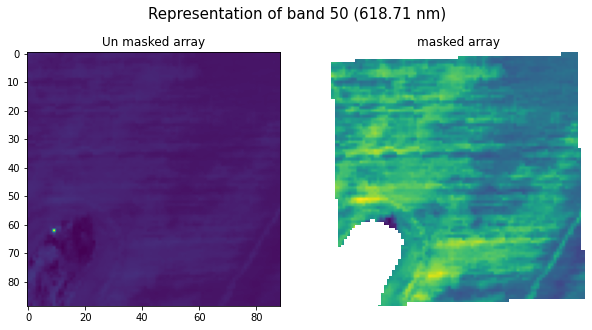

In [12]:
# display a single band 

#choose a sample 
rand_sample_path = train_gt.sample(n=1)['paths'].values[0]


with np.load(rand_sample_path) as f :
    arr = np.ma.MaskedArray(**f)

color_print(f'Shape of the selected sample image {arr.shape} (channels, height,width)')




fig, axs = plt.subplots(1, 2, figsize=(10, 5))
band_id = 50
wavelen = wavelength.loc[band_id-1]


axs[0].imshow(arr[band_id,:,:].data)
plt.axis('off')
axs[0].set_title('Un masked array')

axs[1].imshow(arr[band_id,:,:])
plt.axis('off')
axs[1].set_title('masked array')




plt.suptitle(f'Representation of band {int(wavelen["band_no"])} ({wavelen["wavelength"]} nm)', fontsize=15)
plt.show()

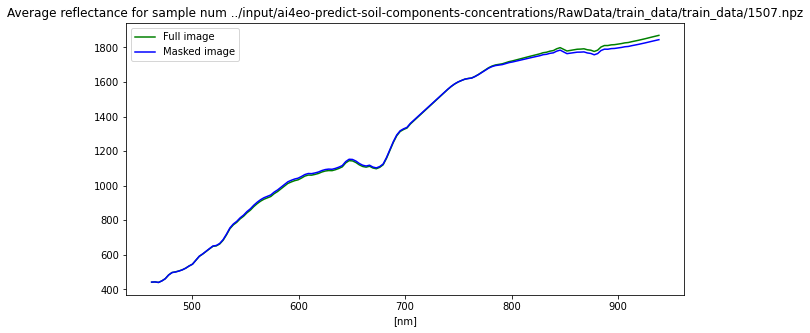

In [13]:
# displaying spectral curve 

fig,ax = plt.subplots(figsize=(10, 5))

masked_scene_mean_spectral_reflectance = [arr[i,:,:].mean() for i in range(arr.shape[0])]
full_scene_mean_spectral_reflectance = [arr[i,:,:].data.mean() for i in range(arr.shape[0])]

plt.plot(wavelength['wavelength'], full_scene_mean_spectral_reflectance, label='Full image',color='g')
plt.plot(wavelength['wavelength'], masked_scene_mean_spectral_reflectance, label='Masked image',color='b')

plt.xlabel('[nm]')
plt.legend()
plt.title(f'Average reflectance for sample num {rand_sample_path}')
plt.show()

**Checking range of data values(for scaling Images)**

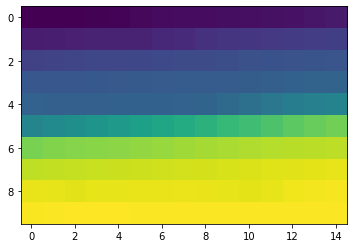

In [14]:
band_vals = []
heights = []
widths = []

for rast in train_gt.paths:
    arr = load_npz_file(rast,masked=True,pad_mask=False)
    
    # take max value 
    max_vals = arr.max(axis=(1,2))
    band_vals.append(max_vals)
    
    # get image heights and widths 
    unmasked = arr.data 
    
    c,h,w = unmasked.shape
    
    heights.append(h)
    widths.append(w)
    
    
    
band_vals= np.array(band_vals)
    
mean_band_vals = band_vals.mean(axis=0)

plt.imshow(mean_band_vals.reshape((10,15)))

**Distribution of Image Height and widths**

    Images have different heights and widths, so lets take a look at that distribution 

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


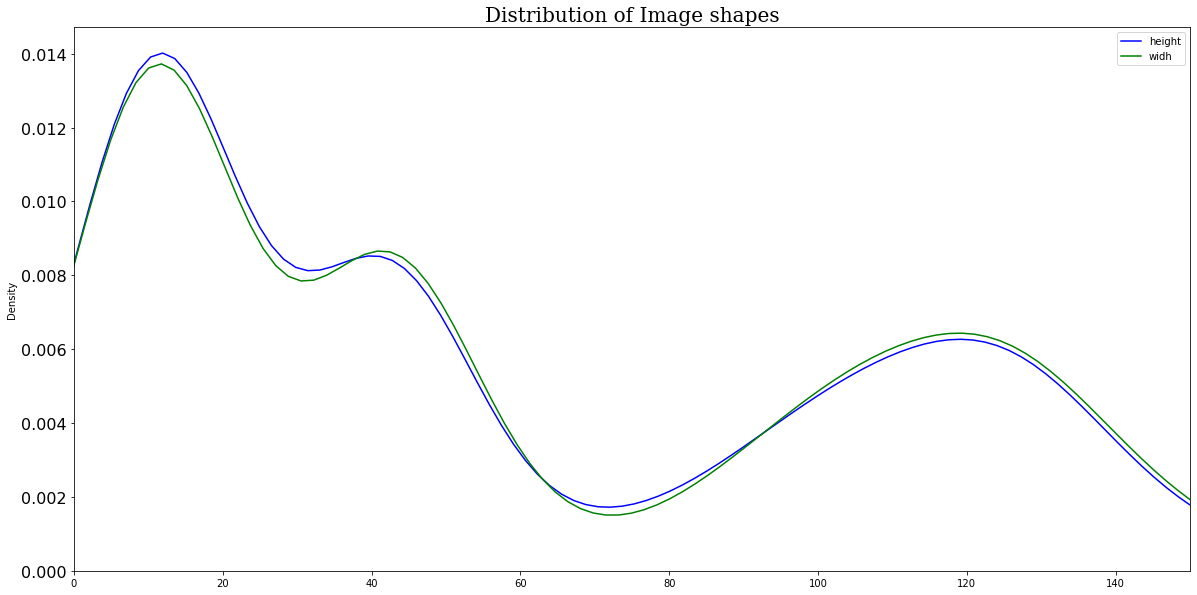

In [15]:
plt.figure(figsize=(20,10))
plt.yticks(fontsize=16)

sns.distplot(a = heights,color = 'b',label = 'height',hist=False)
sns.distplot(a = widths,color = 'g',label = 'widh',hist=False)

plt.title("Distribution of Image shapes",
          font="Serif", 
          size=20,
          color='k')
plt.xlim((0,150))

plt.legend()

plt.show()


# Building Train and test datasets 

In [16]:
def load_and_reshape(filepath):
    '''load and reshape array'''
    
    filepath = filepath.numpy().decode('utf-8')
    
    #load array
    arr = load_npz_file(filepath,
                        masked=True,
                        pad_mask=True)
    
    depth,height,width = arr.shape
    
    # reshape to depth last format 
    arr = arr.reshape((height,width,depth))
    
#     scale values 
    arr = arr / mean_band_vals
    
#     resize 
    arr = cv2.resize(arr,CFG.img_size)
    
    return arr


def process_image(filename):
    '''function for preprocessing in tensorflow data'''
    
    return tf.py_function(load_and_reshape, 
                          [filename], 
                          tf.float32)
    



# Data Pipelines 



In [17]:

train_ds,val_ds = train_test_split(train_gt,
                                  test_size = CFG.validation_size,
                                  random_state = CFG.seed)



train_ds.shape,val_ds.shape

((1385, 6), (347, 6))

In [18]:
def augment_image(image):
    '''perform simple image augmentations'''
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_crop(image, size=(*CFG.img_size,150))
    
    rot = tf.random.normal((1,),mean = 0.35, stddev=0.15)
    
    if rot > 0.5:
        image = tf.image.rot90(image)

    return image 

In [35]:

def get_tf_dataset(image_paths,
                   labels=None, # put none for test data set
                   image_processing_fn=process_image,
                   augment_fn = None
                  ):
    
    '''returns a tf dataset object'''
    
    #seperate datasets
    if labels is not None:
        labels_dataset = tf.data.Dataset.from_tensor_slices(labels)
    
    
    
    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    #load images 
    image_dataset = image_dataset.map(image_processing_fn,
                                      num_parallel_calls=tf.data.AUTOTUNE)
     
    if augment_fn is not None:
        
        image_dataset = image_dataset.map(augment_fn,
                                          num_parallel_calls=tf.data.AUTOTUNE)
     
    
    if labels is not None:
        return tf.data.Dataset.zip((image_dataset,labels_dataset))
    
    
    return image_dataset


def optimize_pipeline(tf_dataset,
                      batch_size = CFG.BATCH_SIZE,
                      Autotune_fn = CFG.Autotune,
                      cache= False,
                      batch = True):
    
    
    
    # prefetch(load the data with cpu,while gpu is training) the data in memory 
    tf_dataset = tf_dataset.prefetch(buffer_size=Autotune_fn)  
    if cache:
        tf_dataset = tf_dataset.cache()                        # store data in RAM  
        
    tf_dataset =  tf_dataset.shuffle(buffer_size=50)         # shuffle 
    
    if batch:
        tf_dataset = tf_dataset.batch(batch_size)              #split the data in batches  
    
    return tf_dataset





Training_Dataset = optimize_pipeline(get_tf_dataset(image_paths = train_ds.paths.values,
                                               labels = train_ds[CFG.classes].values,
                                               image_processing_fn = process_image,
                                              augment_fn=augment_image)
                              )


Val_Dataset = optimize_pipeline(get_tf_dataset(image_paths = val_ds.paths.values,
                                               labels = val_ds[CFG.classes].values,
                                               image_processing_fn = process_image,
                                               augment_fn=augment_image)
                              )



Test_Dataset = optimize_pipeline(get_tf_dataset(image_paths = test_csv.paths.values,
                                               labels = None,
                                               image_processing_fn = process_image,
                                               augment_fn=augment_image)
                              )


**CHeck the dataset**

2022-06-30 04:24:13.142631: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Training data batch : (32, 60, 60, 150)


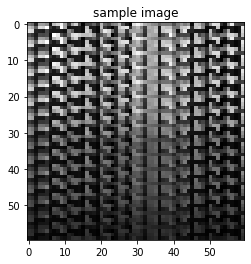

In [20]:
for x,y in Training_Dataset.take(1): # take one batch for checking 
    print(f'Training data batch : {x.shape}')
    
    plt.imshow(x[0,:,:,100],cmap='gray')
    plt.title('sample image')

# Building a cnn

Model Architecture


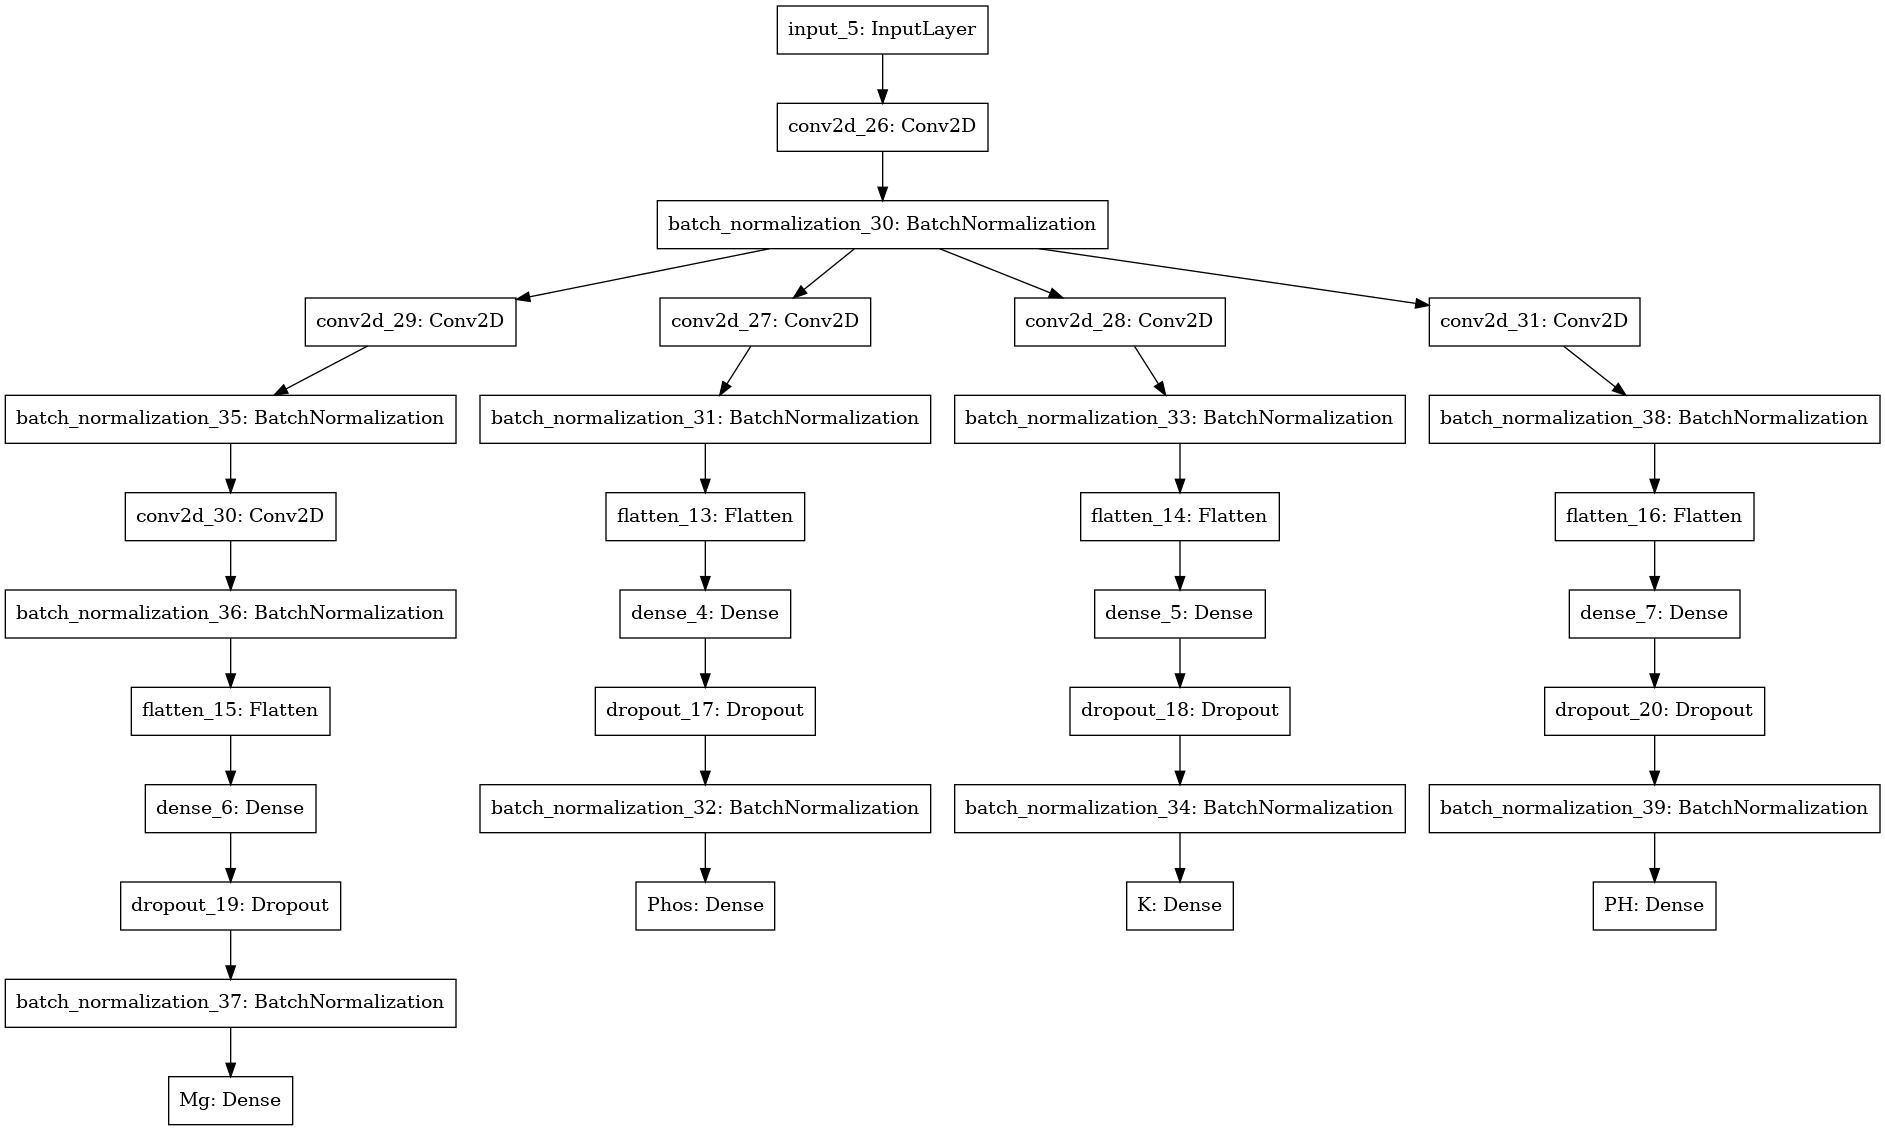

In [31]:
#hidden units in each branch 
n_hidden = [32,32,32,32]



# input layer
inp =tf.keras.layers.Input(shape = (*CFG.img_size,150))




# L1

x0 = tf.keras.layers.Conv2D(32,
           activation='relu',
           kernel_size=7,
           strides =2
          )(inp)

x0 = tf.keras.layers.BatchNormalization()(x0)



# seperate branches for each output 


# phosphorous branch 

x1 = tf.keras.layers.Conv2D(64,
           activation='relu',
           kernel_size=3,
           strides =2
          )(x0)
x1 = tf.keras.layers.BatchNormalization()(x1)


# x1 = tf.keras.layers.Conv2D(128,
#            activation='relu',
#            kernel_size=3,
#            strides =2
#           )(x1)
# x1 = tf.keras.layers.BatchNormalization()(x1)


x1 = tf.keras.layers.Flatten()(x1)
# x1 = tf.keras.layers.Dropout(0.15)(x1)


x1 = tf.keras.layers.Dense(n_hidden[0])(x1)
x1 = tf.keras.layers.Dropout(0.15)(x1)
x1 = tf.keras.layers.BatchNormalization()(x1)

out1 = tf.keras.layers.Dense(1,
                            activation='linear',name = 'Phos')(x1)


# K branch 

x2 = tf.keras.layers.Conv2D(64,
           activation='relu',
           kernel_size=3,
           strides =2
          )(x0)
x2 = tf.keras.layers.BatchNormalization()(x2)


x2 = tf.keras.layers.Flatten()(x2)
# x2 = tf.keras.layers.Dropout(0.15)(x2)



x2 = tf.keras.layers.Dense(n_hidden[1])(x2)
x2 = tf.keras.layers.Dropout(0.15)(x2)
x2 = tf.keras.layers.BatchNormalization()(x2)



out2 = tf.keras.layers.Dense(1,
                            activation='linear',name = 'K')(x2)

# mg branch 

x3 = tf.keras.layers.Conv2D(64,
           activation='relu',
           kernel_size=3,
           strides =2
          )(x0)
x3 = tf.keras.layers.BatchNormalization()(x3)


x3 = tf.keras.layers.Conv2D(128,
           activation='relu',
           kernel_size=3,
           strides =2
          )(x3)
x3 = tf.keras.layers.BatchNormalization()(x3)


x3 = tf.keras.layers.Flatten()(x3)
# x3 = tf.keras.layers.Dropout(0.15)(x3)
x3 = tf.keras.layers.Dense(n_hidden[2])(x3)
x3 = tf.keras.layers.Dropout(0.15)(x3)
x3 = tf.keras.layers.BatchNormalization()(x3)

out3 = tf.keras.layers.Dense(1,
                            activation='linear',name = 'Mg')(x3)


# ph branch 

x4 = tf.keras.layers.Conv2D(64,
           activation='relu',
           kernel_size=3,
           strides =2
          )(x0)
x4 = tf.keras.layers.BatchNormalization()(x4)

x4 = tf.keras.layers.Flatten()(x4)
# x4 = tf.keras.layers.Dropout(0.25)(x4)



x4 = tf.keras.layers.Dense(n_hidden[3])(x4)
x4 = tf.keras.layers.Dropout(0.15)(x4)
x4 = tf.keras.layers.BatchNormalization()(x4)


out4 = tf.keras.layers.Dense(1,
                            activation='linear',name = 'PH')(x4)


model = tf.keras.Model(inputs=[inp],outputs = [out1,out2,out3,out4])




print('Model Architecture')

tf.keras.utils.plot_model(model)

# Training

In [32]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.05),
              loss = 'mean_squared_error',
              metrics = tf.keras.metrics.MAE)


# to save model 
!mkdir CNN_models

mkdir: cannot create directory ‘CNN_models’: File exists


In [33]:
EPOCHS = 100
# callbacks 
#reduce_learning rate
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(patience=2,
                                                factor=0.75,
                                                min_delta=1e-2,
                                                monitor='val_loss',
                                                verbose=1,
                                                mode='min')

#early stopping 
early_stopping=tf.keras.callbacks.EarlyStopping(patience=10,
                                             min_delta=1e-2,
                                              monitor='val_loss',
                                              restore_best_weights=True,
                                              mode='min')


# exponential decay 

def lr_scheduler(epoch, lr):

    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.02)
    

    
learning_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)



callbacks_1= [reduce_lr,early_stopping,learning_scheduler]



hist1 = model.fit(Training_Dataset,
                    validation_data = Val_Dataset,
                    epochs = EPOCHS,
                    callbacks = callbacks_1
                   )


model.save(filepath = 'CNN_models/CNN_model.h5')


Epoch 1/100
44/44 [==============================] - 59s 1s/step - loss: 88188.4375 - Phos_loss: 22038.3066 - K_loss: 22056.9043 - Mg_loss: 22031.2832 - PH_loss: 22061.9375 - Phos_mean_absolute_error: 115.2726 - K_mean_absolute_error: 115.3600 - Mg_mean_absolute_error: 115.2388 - PH_mean_absolute_error: 115.4214 - val_loss: 79062.5391 - val_Phos_loss: 21549.9355 - val_K_loss: 20760.7031 - val_Mg_loss: 16205.5586 - val_PH_loss: 20546.3438 - val_Phos_mean_absolute_error: 114.9228 - val_K_mean_absolute_error: 112.7327 - val_Mg_mean_absolute_error: 98.1386 - val_PH_mean_absolute_error: 112.0324
Epoch 2/100
44/44 [==============================] - 55s 1s/step - loss: 83185.5859 - Phos_loss: 20770.0703 - K_loss: 20830.7227 - Mg_loss: 20756.4062 - PH_loss: 20828.3789 - Phos_mean_absolute_error: 110.3709 - K_mean_absolute_error: 110.6160 - Mg_mean_absolute_error: 110.3969 - PH_mean_absolute_error: 110.6004 - val_loss: 76810.3984 - val_Phos_loss: 19339.1250 - val_K_loss: 19662.0625 - val_Mg_los

KeyboardInterrupt: 

# Prediction on the test set

In [28]:
#evaluate on validatio datat 

_ = model.evaluate(Val_Dataset)

11/11 [==============================] - 10s 711ms/step - loss: 33941.9297 - Phos_loss: 8506.8047 - K_loss: 8486.1494 - Mg_loss: 8477.3115 - PH_loss: 8471.6641 - Phos_mean_absolute_error: 78.6295 - K_mean_absolute_error: 78.5903 - Mg_mean_absolute_error: 78.5484 - PH_mean_absolute_error: 78.5205


[33941.9296875,
 8506.8046875,
 8486.1494140625,
 8477.3115234375,
 8471.6640625,
 78.62947845458984,
 78.59029388427734,
 78.54840850830078,
 78.52047729492188]

**predict using TTA (test time augmentations)**

    We will basically use the same augmentations used in training, and predict multiple times on the test set. This will smoothen out the error in prediction

In [43]:
def TTA_prediction(model,  # trained model 
                   test_dataset, # should have augmentation (random)
                   num_repeats): # num of repreats 
    preds = []
    
    for _ in tqdm(iterable = range(num_repeats),desc='Prediction Number'):
        pred = model.predict(test_dataset)
        
        preds.append(pred)
        
    
    preds = np.array(preds)
    
    return preds


def mean_preds(predictions,axis=0):
    
    return predictions.mean(axis=axis).T.squeeze(axis=0)

def median_preds(predictions,axis=0):
    
    return np.median(predictions,axis=axis).T.squeeze(axis=0)



preds = TTA_prediction(model=model,
                      test_dataset = Test_Dataset,
                      num_repeats= 10)


#mean of predictions
mean_pred_val = pd.DataFrame(mean_preds(preds),
                            columns =['P', 'K', 'Mg', 'pH'] )


# median of predictions
med_pred_val = pd.DataFrame(median_preds(preds),
                             columns =['P', 'K', 'Mg', 'pH'])


# Distribution of predictions 

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


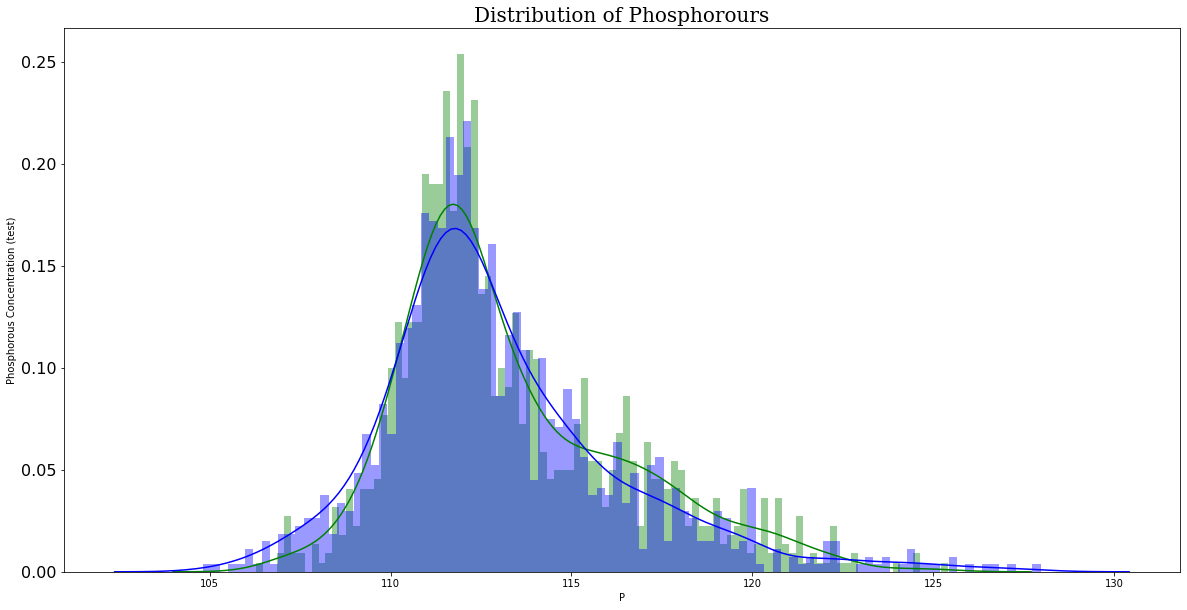

In [44]:
plt.figure(figsize=(20,10))
plt.yticks(fontsize=16)
sns.distplot(a = mean_pred_val['P'],bins = 100,color = 'g',label='mean')
sns.distplot(a = med_pred_val['P'],bins = 100,color = 'b',label='median')

plt.title("Distribution of Phosphorours",
          font="Serif", 
          size=20,
          color='k')
plt.ylabel('Phosphorous Concentration (test)')

plt.show()


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


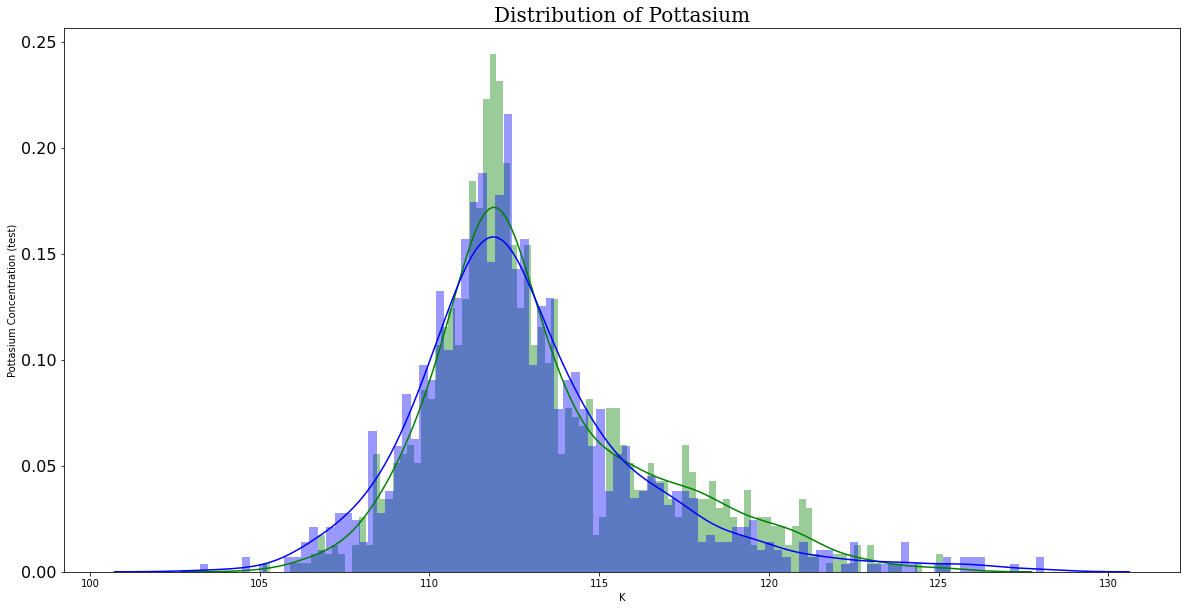

In [45]:
plt.figure(figsize=(20,10))
plt.yticks(fontsize=16)
sns.distplot(a = mean_pred_val['K'],bins = 100,color = 'g',label='mean')
sns.distplot(a = med_pred_val['K'],bins = 100,color = 'b',label='median')

plt.title("Distribution of Pottasium",
          font="Serif", 
          size=20,
          color='k')
plt.ylabel('Pottasium Concentration (test)')

plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


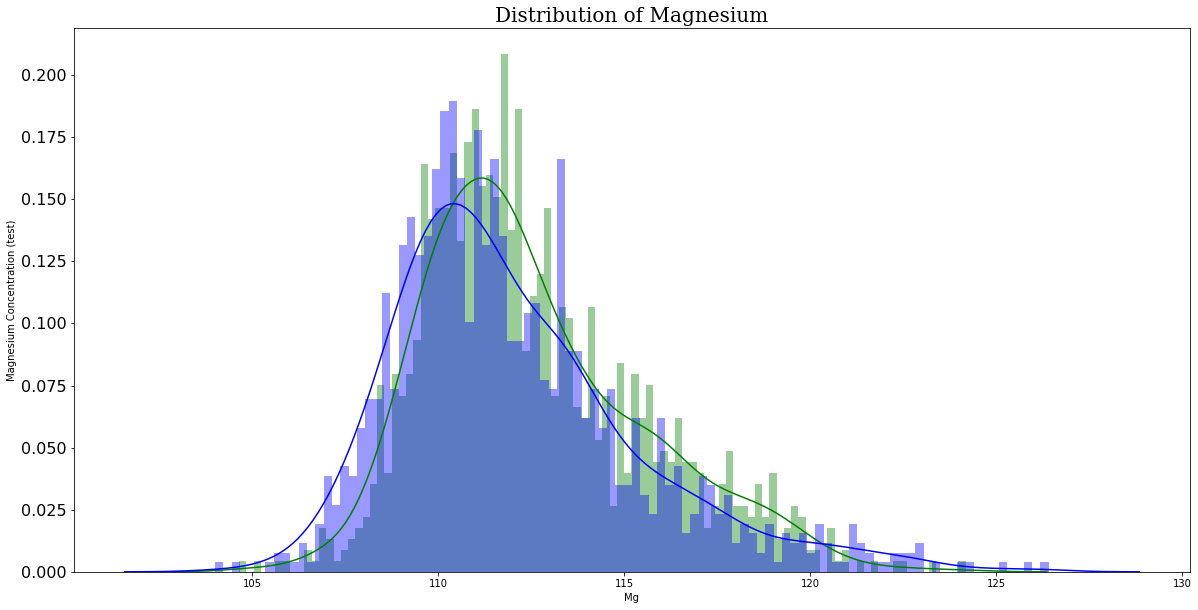

In [46]:
plt.figure(figsize=(20,10))
plt.yticks(fontsize=16)
sns.distplot(a = mean_pred_val['Mg'],bins = 100,color = 'g',label='mean')
sns.distplot(a = med_pred_val['Mg'],bins = 100,color = 'b',label='median')

plt.title("Distribution of Magnesium",
          font="Serif", 
          size=20,
          color='k')
plt.ylabel('Magnesium Concentration (test)')

plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


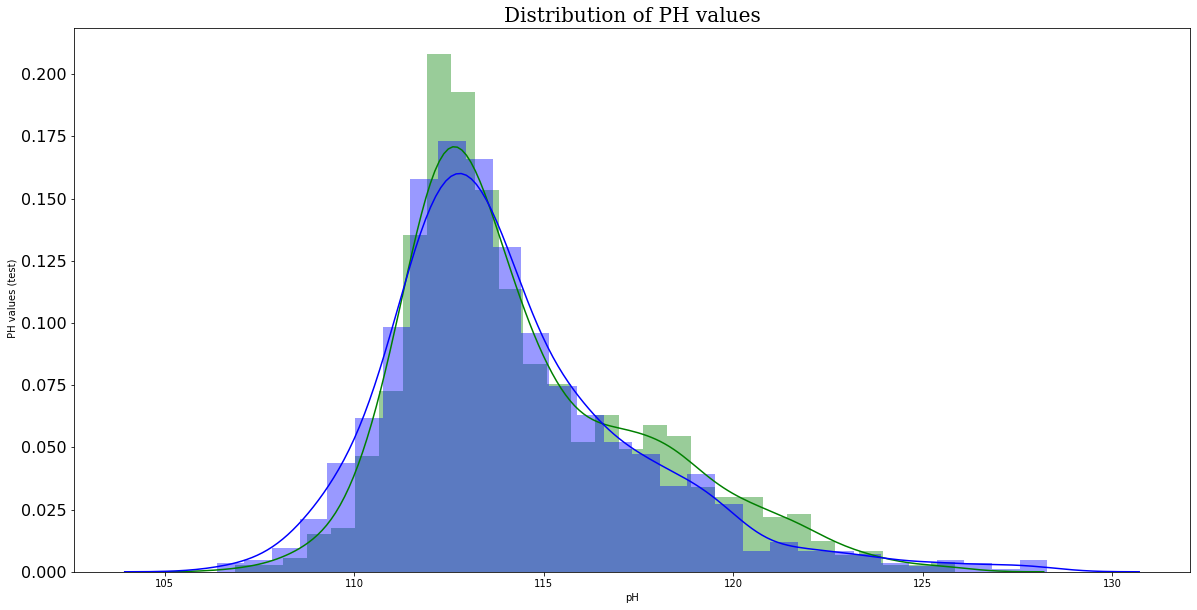

In [47]:
plt.figure(figsize=(20,10))
plt.yticks(fontsize=16)
sns.distplot(a = mean_pred_val['pH'],bins = 30,color = 'g',label='mean')
sns.distplot(a = med_pred_val['pH'],bins = 30,color = 'b',label='median')

plt.title("Distribution of PH values",
          font="Serif", 
          size=20,
          color='k')
plt.ylabel(' PH values (test)')

plt.show()

# Submission

In [48]:
mean_pred_val.to_csv("pred_mean.csv",index_label="sample_index")

!zip mean_sub.zip pred_mean.csv
!rm pred_mean.csv

  adding: pred_mean.csv (deflated 59%)


In [49]:
med_pred_val.to_csv("pred_med.csv",index_label="sample_index")

!zip med_sub.zip pred_med.csv
!rm pred_med.csv

  adding: pred_med.csv (deflated 59%)


In [50]:
!ls

CNN_models  __notebook_source__.ipynb  mean_sub.zip  med_sub.zip  model.png
